In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.set_printoptions(precision=3, linewidth=500, threshold=500, suppress=True, edgeitems=5)

%load_ext autoreload
%autoreload 2
%matplotlib ipympl

In [2]:
from ndgsp.graph.graphs import Graph, ProductGraph
from ndgsp.graph.filters import MultivariateFilterFunction

from PIL import Image
import matplotlib.patches as mpatches
import matplotlib
import scipy as sp

import matplotlib as mpl
from matplotlib.path import Path
from matplotlib.patches import PathPatch

import subprocess 

import time
from tqdm.notebook import tqdm

import sys

sys.path.append('..')

from utils.plotting import to_colors

import ast



2023-03-25 17:05:53.545516: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


Using Jax backend with device TFRT_CPU_0


PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `T-V.pdf'.


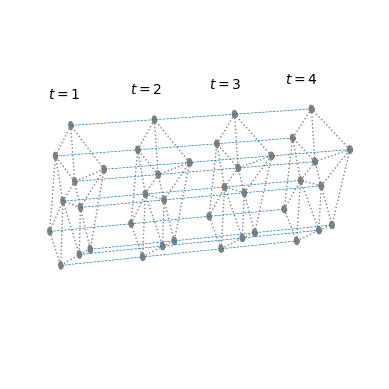

In [14]:
def plot_TV_graph():
    """
    Plot a diagram depicting a time-vertex product graph
    """

    ax = plt.figure().add_subplot(projection='3d')

    np.random.seed(1)

    x = 2 * np.random.uniform(0, 10, size=10)
    z = 2 * np.random.uniform(0, 10, size=10)

    def add_point(x, y, z, r=1):

        theta = np.linspace(0, 2 * np.pi, 20)
        x_ = r * np.cos(theta) + x
        z_ = r * np.sin(theta) + z
        y_ = np.zeros_like(x_) + y

        ax.plot(x_, y_, z_, c='gray', lw=2)

    def add_edge(i, j, y):
        ax.plot([x[i], x[j]], [y, y], [z[i], z[j]], color='gray', lw=1, ls=':')


    edges  = [(0, 9),(0, 8),(0, 7),(0, 6),(0, 1),(1, 9),(1, 7),(1, 3),(3, 7),(3, 5), 
              (6, 7),(5, 6),(6, 8),(2, 5),(2, 6),(2, 4),(4, 6),(4, 8),(8, 9), (7, 5)]

    z0 = 0
    z1 = 10

    for y in np.linspace(z0, z1, 4):

        for i, j in edges:

            add_edge(i, j, y)



    for y in np.linspace(z0, z1, 4):


        for xx, zz in zip(x, z):

            add_point(xx, y, zz, 0.35)

    for xx, zz in zip(x, z):

        ax.plot([xx, xx], [z0, z1], [zz, zz], color='tab:blue', ls='--', lw=0.5)


    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    ax.set_box_aspect([1, 2, 1])

    ax.set_axis_off()

    ax.view_init(9.54, -27.85)

    for i, y in enumerate(np.linspace(z0, z1, 4)):


        ax.text(0, y, 20, f'$t={i+1}$')

    plt.savefig('T-V.pdf')

    subprocess.run(['pdfcrop', 'T-V.pdf', 'T-V.pdf'])

plot_TV_graph()

In [56]:
def verify_eig_of_path_graph():
    """
    This function demonstrates that the eigenvalues and eigenvectors
    of the path graph are as given in the thesis
    """


    T = 101
    G = Graph.chain(T)

    # compute eigen-decomposition using closed-form solution 
    lam = 2 - 2 * np.cos(T ** -1 * np.pi * np.arange(T))
    U = np.cos(T ** -1 * np.pi * np.outer(np.arange(T) + 0.5, np.arange(T)))
    U /= np.linalg.norm(U, axis=0)

    # check the decomposition recreates the Laplacian
    assert np.allclose(G.L, U @ np.diag(lam) @ U.T)

    return True


verify_eig_of_path_graph()

True

In [75]:
def verify_DCT():
    """
    This function verifies that the GFT and the IGFT are given by the Discrete 
    Cosine Transform (DCT) and the Inverse DCT respectively. 
    """

    def Uy(y):
        return sp.fft.idct(y.T, type=2, norm='ortho').T

    def UTy(y):
        return sp.fft.dct(y.T, type=2, norm='ortho').T

    def yU(y):
        return sp.fft.dct(y, type=2, norm='ortho')

    def yUT(y):
        return sp.fft.idct(y, type=2, norm='ortho')

    T = 101

    # compute eigen-decomposition using closed-form solution 
    U = np.cos(T ** -1 * np.pi * np.outer(np.arange(T) + 0.5, np.arange(T)))
    U /= np.linalg.norm(U, axis=0)

    for shape in [(T), (T, 5), (5, T)]:

        y = np.random.normal(size=shape)
        
        if shape != (5, T):
            assert np.allclose(U.T @ y, UTy(y))
            assert np.allclose(U @ y, Uy(y))

        if shape != (T, 5):
            assert np.allclose(y @ U.T, yUT(y))
            assert np.allclose(y @ U, yU(y))

    return True

verify_DCT()


True

In [19]:
def plot_MM_vs_CDT():
    """
    Plot a graph demonstrating the difference in compute time across a range 
    of T values for matrix multiplication vs the DCT for GFT of the path graph. 
    """

    Ts = np.linspace(10, 1.5e4, 20).astype(int)
    ts_gft = []
    ts_dct = []

    for T in tqdm(Ts):

        U = np.cos( np.pi * np.outer(np.arange(T) + 0.5, np.arange(T)) / T)
        U /= np.linalg.norm(U, axis=0)

        y = np.random.normal(size=T)

        t0 = time.time()
        for i in range(5):
            U.T @ y
        ts_gft.append((time.time() - t0) / 5)

        t0 = time.time()
        for i in range(5):
            sp.fft.dct(y, type=2, norm='ortho')
        ts_dct.append((time.time() - t0) / 5)

    plt.figure()

    plt.plot(Ts, ts_gft, label='Matrix multiplication')
    plt.plot(Ts, ts_dct, label='FCT')

    plt.legend()

    plt.xlabel('$T$')
    plt.ylabel('Time [s]')

    plt.xticks(np.arange(0, 15001, 2500))

    plt.savefig('DCT.pdf', transparent=True)

    
plot_MM_vs_CDT()

  0%|          | 0/20 [00:00<?, ?it/s]

In [3]:
def get_uk_covid_data():

    regions = pd.read_csv('data/regions.csv', index_col=0)
    regions['coords'] = regions['coords'].apply(lambda item: ast.literal_eval(item))   
    cases = pd.read_csv('data/case_rate_per_thousand.csv', index_col=0, parse_dates=True)

    return regions, cases

    

In [4]:
regions, cases = get_uk_covid_data()

In [22]:
def get_adjacency_matrix():

    paths = {code: [Path(np.squeeze(coords)) for coords in coords_list] for code, coords_list in zip(regions.index.tolist(), regions['coords'])}

    A = np.zeros((len(paths), len(paths)))

    for i, plist1 in tqdm(enumerate(paths.values()), total=A.shape[0]):

        for j, plist2 in enumerate(paths.values()):

            if i == j:
                break

            for path1 in plist1:
                for path2 in plist2:
                    if path1.intersects_path(path2):
                        A[i, j] = 1
                        A[j, i] = 1

    return A

def get_centroids():
        
    paths = {code: [Path(np.squeeze(coords)) for coords in coords_list] for code, coords_list in zip(regions.index.tolist(), regions['coords'])}
    centroids = np.array([max(path_list, key= lambda path: len(path)).vertices.mean(0) for path_list in paths.values()])

    return centroids


PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `UK_covid.pdf'.


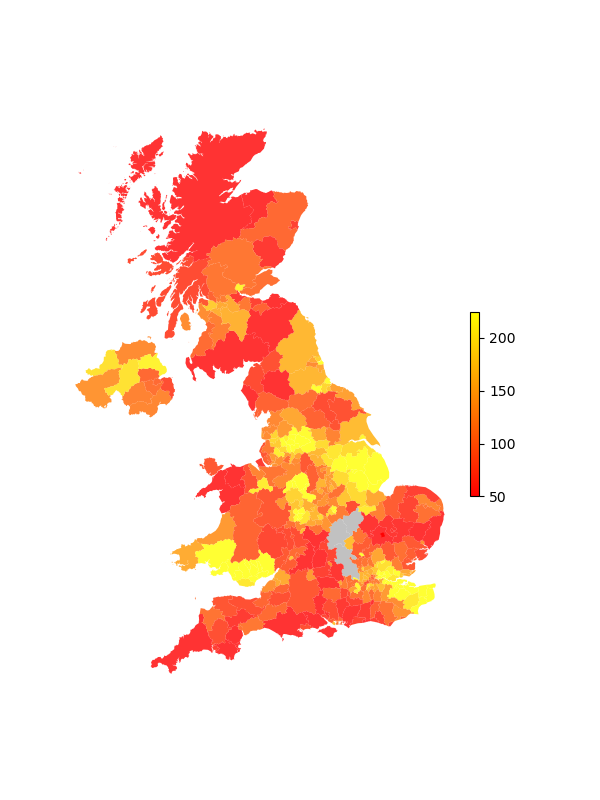

In [242]:
def plot_uk_covid():
    
    patches = {}
    t = 300

    # vmin = np.nanpercentile(cases.iloc[t].values, 5)
    # vmax = np.nanpercentile(cases.iloc[t].values, 90)

    vmin = 50
    vmax = 225
    colors = to_colors(cases.iloc[t].values, cmap='autumn', vmin=vmin, vmax=vmax)
    fig, ax = plt.subplots(figsize=(6, 8))

    for code, coord_list, color in zip(regions.index, regions['coords'], colors):
        patches[code] = []

        for coords in coord_list:

            coords = np.squeeze(coords)
            patches[code].append(ax.add_patch(PathPatch(Path(coords), alpha=0.8, facecolor=color, edgecolor='white', linewidth=0)))

    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='autumn'), ax=ax, shrink=0.3, drawedges=False)

    ax.set_xlim(0, 0.66e6)
    ax.set_ylim(0, 0.98e6)
    ax.set_aspect('equal')
    plt.axis('off')

    plt.savefig('UK_covid.pdf')
    subprocess.run(['pdfcrop', 'UK_covid.pdf', 'UK_covid.pdf'])

plot_uk_covid()


In [62]:
Y0 = np.log(10 + cases)

Y0 = (Y0 - Y0.stack().mean()) / Y0.stack().std()

In [220]:
def remove_random_uniform(Y0, m: float, seed: int=0):
    """
    Add nans to a signal uniformly at random, such that a total fraction
    of approximately m is removed
    """

    np.random.seed(seed)
    non_nulls = np.argwhere(~Y0.isnull().values)
    N = len(non_nulls)
    M = int(m * N)
    inds = non_nulls[np.random.choice(N, size=M, replace=False)]
    Y1 = Y0.copy()
    Y1.values[inds[:, 0], inds[:, 1]] = np.nan

    return Y1, Y1.isnull()


def remove_random_strings(Y0, m: float, str_len: int, seed: int=0):    
    """
    Add nans to a signal by randomly selecting strings of dates to be removed
    at each node, such that a total fraction of approximately m is removed
    """

    np.random.seed(seed)

    all_out = []
    for i in range(Y0.shape[1]):

        t = 0
        out = np.zeros(Y0.shape[0], dtype=bool)

        while t < Y0.shape[0] - str_len:

            if np.random.uniform(0, 1) < ((1 + 1.5 * m) * m / str_len):
                out[t:t+str_len] = True
                t += str_len

            else:
                t += 1

        all_out.append(out)

    Y1 = Y0.copy()
    Y1.values[np.array(all_out).T] = np.nan

    return Y1, Y1.isnull()


def remove_random_nodes(Y0, m: float, seed: int=0):
    """
    Add nans to a signal by randomly removing the entire time series for a particular 
    node such that a total fraction of approximately m is removed
    """


    np.random.seed(seed)

    n_cols = int(m * Y0.shape[1])

    Y1 = Y0.copy()

    Y1.iloc[:, np.random.choice(Y0.shape[1], size=n_cols, replace=False)] = np.nan

    return Y1, Y1.isnull()


def remove_random_times(Y0, m: float, seed: int=0):
    """
    Add nans to a signal by randomly removing the signal at all nodes for a particular 
    time such that a total fraction of approximately m is removed
    """

    np.random.seed(seed)

    n_rows = int(m * Y0.shape[0])
    
    Y1 = Y0.copy()

    Y1.iloc[np.random.choice(Y0.shape[0], size=n_rows, replace=False), :] = np.nan

    return Y1, Y1.isnull()
    

In [233]:
def get_RMSE(Y0, predicted_inds, F):
    return (np.nansum((Y0.values[predicted_inds.values] - F.values[predicted_inds.values]) ** 2) / predicted_inds.values.sum()) ** 0.5



In [212]:
def interpolate(Y):
    return Y.interpolate().ffill().bfill()
    

In [238]:
Y1, inds = remove_random_strings(Y0, 0.1, 100)

In [239]:
F = interpolate(Y1)

In [240]:
get_RMSE(Y0, inds, F)

0.4360844692485193